In [1]:
import pandas as pd
import numpy as np
import zipfile
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Concatenate,Dropout,Embedding,LayerNormalization,add
from tensorflow.keras.models import Model

- Attempting to implement Masked Self Attention used in GPT/Transformer decoder block.

- For experimental purpose using ecommerce sessions data instead of text data to test code.

- Using various NLP techiniques like embeddings, w2v, masked self attention on sessions data.

Getting Data:

In [ ]:
!pip install kaggle
from google.colab import files
api_token = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d retailrocket/ecommerce-dataset -f events.csv

In [ ]:
files = zipfile.ZipFile('/content/events.csv.zip', mode="r")
files.extractall('/content/')
files.close()

In [ ]:
events = pd.read_csv('events.csv')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Splitting Data:

In [ ]:
events['timestamp'] = events['timestamp'].apply(lambda i : datetime.datetime.fromtimestamp(int(i)/1000))
print('start date:', events.timestamp.values.min())
print('end data:', events.timestamp.values.max())

start date: 2015-05-03T03:00:04.384000000
end data: 2015-09-18T02:59:47.788000000


In [ ]:
# we have 4 months, 15 days data
# doing simple splitting. using last 1 month data as validation data
events_train = events[events['timestamp']<='2015-08-18 00:00:00']
events_val = events[events['timestamp']>'2015-08-18 00:00:00']

<font color='red'>Converting events data to sessions data:</font>

Getting simple list of itemid's for every unique visitor, sorted by date-time.

Considering only those visitorid where sessions length is more than 3.

In [ ]:
def sessions_array(event_df):
  event_grp = event_df[['timestamp','visitorid','itemid']].groupby('visitorid') # groupby on every visitor id on required data
  sessions=[]
  for _,grp in event_grp:
    single_session = grp.sort_values('timestamp')['itemid'].values # sorting on timestamp
    if len(single_session)>3:
      sessions.append(single_session) # appending itemid list for a unique visitorid as per timeline
  return sessions

In [ ]:
sessions_train = sessions_array(events_train)
sessions_val = sessions_array(events_val)

In [ ]:
sessions_train[:5]

[array([325215, 325215, 259884, 216305, 342816, 342816, 216305, 325215]),
 array([168952, 168952, 168952, 168952, 168952, 168952, 434344, 168952]),
 array([141657, 295653, 233200, 118401, 224700, 160984, 160984]),
 array([ 52383, 168656,  52383, 353515]),
 array([ 45410,  59574,  57171,  57171,  57171, 262125,  55826])]

In [ ]:
#import pickle
#with open('/content/drive/MyDrive/recommender/data_sessions.pkl', 'wb') as handle:
#  pickle.dump((sessions_train,sessions_val), handle, protocol=pickle.HIGHEST_PROTOCOL) 

<font color='red'>Tokenizing itemid:</font>

As itemid are not in numerical order we are tokenizing.

In [2]:
import pickle
with open('/content/drive/MyDrive/recommender/data_sessions.pkl', 'rb') as handle:
    d = pickle.load(handle)

In [3]:
sessions_train=d[0]
sessions_val=d[1]

In [4]:
items_unique = np.unique([id for sess in sessions_train for id in sess]) # getting list of unique itemid
vocabulary = {j:i+1 for i,j in enumerate(items_unique)} # tokenizing, starting token from 1

In [5]:
def item_tokenizer(sessions,vocabulary):
  session_tokenized = []
  for sess in sessions:
    single_session = []
    for id in sess:
      try:
        single_session.append(vocabulary[id])
      except:
        single_session.append(len(vocabulary)+1) #out of word token
    session_tokenized.append(single_session)
  return session_tokenized

In [6]:
train_session = item_tokenizer(sessions_train,vocabulary)
val_session = item_tokenizer(sessions_val,vocabulary)

In [ ]:
def unknown_item_percent(session_list,oov_token):
  item_list = np.hstack(session_list)
  count = 0
  for i in item_list:
    if i == oov_token:
      count = count + 1
  return count/len(item_list)

In [ ]:
unknown_item_val = unknown_item_percent(val_session,len(vocabulary)+1)
unknown_item_val

0.135984804638584

Unseen items in validation data is 13.6%

In [ ]:
unique_item_train , unique_item_train_count = np.unique(np.hstack(train_session) , return_counts=True)

In [ ]:
print('Unique items in train data:',len(unique_item_train))
print('No. of sessions in train data:',len(train_session))
print('\nNo. of items appearing only one time in train data:',len(np.where(unique_item_train_count==1)[0]))
print('No. of items appearing only two times in train data:',len(np.where(unique_item_train_count==2)[0]))
print('No. of items appearing only three times in train data:',len(np.where(unique_item_train_count==3)[0]))

Unique items in train data: 101047
No. of sessions in train data: 96123

No. of items appearing only one time in train data: 34495
No. of items appearing only two times in train data: 14527
No. of items appearing only three times in train data: 8884


In [ ]:
np.quantile(unique_item_train_count , [0.25,0.5,0.75,.9,.95,.99])

array([ 1.,  3.,  8., 20., 35., 92.])

We see that no. of items are more than the sessions data avilable.

About 50% items appear less than 3 times.

<font color='red'> Using w2v to get item embeddings </font>

Items appearing close together in an session will have high similarity in embedding space.

In [7]:
# converting itemid token to string to become usable in gensim w2v model
w2v_corpus = []
for i in range(len(train_session)):
  w2v_corpus.append([str(token) for token in train_session[i]])

In [27]:
from gensim.models import Word2Vec
model_w2v = Word2Vec(sentences=w2v_corpus,\
                     size=128,\
                     window =2,\
                     min_count=1)

<font color='red'> Embedding Matrix </font>

In [28]:
embedding_matrix = []
for i in range(0,len(vocabulary)+2):
  try:
    embedding_matrix.append(model_w2v.wv.get_vector(i))
  except KeyError:
    embedding_matrix.append(np.random.normal(size=(128,)))
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

(101049, 128)

In [ ]:
#with open('/content/drive/MyDrive/recommender/embedding_matrix.pkl', 'wb') as handle:
 # pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL) 

<font color='red'> Creating Train-Test Dataset: </font>

eg: if sessions length is 10, using first 9 items as train and all items except first as test.

if sessions data = [1,2,3,4,5,6,7,8,9,10]

train = [  1,  2,  3,  4,  5,  6,  7,  8,  9  ]

test =  [  2,  3,  4,  5,  6,  7,  8,  9,  10 ]

In [10]:
def train_test_data(sessions):
  train=[]
  test=[]
  for s in sessions:
    train.append(s[:-1])
    test.append(s[1:])
  return train,test

In [11]:
train, y_train = train_test_data(train_session)
val, y_val = train_test_data(val_session)

In [ ]:
train[0], y_train[0]

([25396, 52986, 41642, 21317, 40107, 28801],
 [52986, 41642, 21317, 40107, 28801, 28801])

In [ ]:
(train, y_train), (val, y_val), (test, y_test) = train_test_data

In [ ]:
len(train), len(y_train)

(96123, 96123)

<font color='red'> Padding Data: </font>

In [ ]:
# getting length of each session
len_train=[]
for sess in train:
  len_train.append(len(sess))

In [ ]:
np.quantile(len_train,[0.5,0.75,0.9,0.95,0.99])

array([ 4.,  7., 13., 20., 51.])

In [12]:
# taking max_length as 15
max_length = 15
train_pad = tf.keras.utils.pad_sequences(train, maxlen=max_length, padding='post')
val_pad = tf.keras.utils.pad_sequences(val, maxlen=max_length, padding='post')
y_train_pad = tf.keras.utils.pad_sequences(y_train, maxlen=max_length, padding='post')
y_val_pad = tf.keras.utils.pad_sequences(y_val, maxlen=max_length, padding='post')

<font color='red'> Implementing Self Attention Mechanism:</font>

In [13]:
class SelfAttention(tf.keras.layers.Layer):
  '''
    Class that perfoems masked self attention
  '''
  def __init__(self,attn_dim,dropout,initializer=tf.keras.initializers.RandomNormal(seed=92)):
    super().__init__()
    self.attn_dim = attn_dim   # dim of query,key,value
    self.dropout = dropout
    self.initializer = initializer

  def get_config(self):
      config = super().get_config()
      config.update({
          'att_dim': self.att_dim, 'initializer': self.initializer, 
          })
      return config

  def build(self,input_shape):
    self.q = Dense(self.attn_dim,use_bias=False)
    self.k = Dense(self.attn_dim,use_bias=False)
    self.v = Dense(self.attn_dim,use_bias=False)

  def call(self,input_item):
    drop = Dropout(self.dropout)(input_item) # input_item shape = [b,input_len,embed_dim]
    query = self.q(drop) # [b,input_len,attn_dim]
    key = self.k(drop) # [b,input_len,attn_dim]
    value = self.v(drop) # [b,input_len,attn_dim]
    similarity = tf.matmul(query,key,transpose_b=True)/self.attn_dim**0.5  #[b,input_len,input_len]
    mask = np.tril(np.ones((input_item.shape[1],input_item.shape[1]))).astype(np.float32) # [input_len*input_len] (lower traingular)
    mask[mask == 0] = -1e10 # replacing 0 with a small no.
    similarity_masked = similarity * tf.convert_to_tensor(mask) # [b,input_len,input_len] # masked for self attention
    similarity_softmax =  tf.nn.softmax( similarity_masked ,axis=-1 ) # [b,input_len,input_len]  
    value_weighted = tf.matmul(similarity_softmax,value) # [b,input_len,attn_dim]
    return value_weighted

<font color='red'> Loss Function: </font>

In [14]:
# https://www.tensorflow.org/tutorials/text/image_captioning#losses_and_metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros."""
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

<font color='red'> Model: </font>

- After embedding item token doing layer norm (as layer norm makes item vectors of unit length, may help attention dot product operation instead of batch norm which normalizes feature wise over batch not itemwise).
- Using w2v model to get item embeddings. Items appearing close together in an session will have high similarity in embedding space.
- Using 4 MaskedAttention Head as Multi-Headed Attention and concatenating 4 outputs. The four output are like filters in cnn. Each head will learn different attention weights.
- Again layer normalizing and projecting back to embedding dimension for Residual connection.
- Sending layer normalize output after residual connection to feed forward dense layer.
- For Residual connection, projecting feed forwad output to embedding dimension.
- Getting logits value for each item token.
- afterwards trying to implement sampled softmax to reduce no. of calculations in last layer.

In [30]:
embed_dim= 128
attn_units = 100
dropout = 0.2
no_items=embedding_matrix.shape[0]

input_layer = Input(shape=(max_length,)) # (b,15,)
embed = Embedding(no_items, embed_dim, weights= [embedding_matrix], input_length=max_length, trainable=False)(input_layer) # (b,15,128)
lnorm1 = LayerNormalization()(embed)
attn1 = SelfAttention(attn_units,dropout)(lnorm1) # (b,15,100)
attn2 = SelfAttention(attn_units,dropout)(lnorm1)
attn3 = SelfAttention(attn_units,dropout)(lnorm1)
attn4 = SelfAttention(attn_units,dropout)(lnorm1)
concat = Concatenate()([attn1,attn2,attn3,attn4]) # (b,15,100*4)
lnorm2 = LayerNormalization()(concat)
projection1 = Dense(embed_dim,'relu')(lnorm2) # (b,15,128)
add1 = add([lnorm1,projection1]) # (b,15,128)
lnorm3 = LayerNormalization()(add1)
dropout1 = Dropout(dropout)(lnorm3)
dense = Dense(128,'relu')(dropout1) # (b,15,128)
projection2 = Dense(embed_dim,'relu')(dense) # (b,15,128)
add2 = add([add1,projection2]) # (b,15,128)
lnorm4 = LayerNormalization()(add2)
out = Dense(no_items,activation=None)(lnorm4) # (b,15,len(vocabulary)+1) # logits
model = Model(inputs=input_layer,outputs=out)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 15, 128)      12934272    ['input_6[0][0]']                
                                                                                                  
 layer_normalization_20 (LayerN  (None, 15, 128)     256         ['embedding_5[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 self_attention_20 (SelfAttenti  (None, 15, 100)     38400       ['layer_normalization_20[0]

We see that, no. of parameters are high.

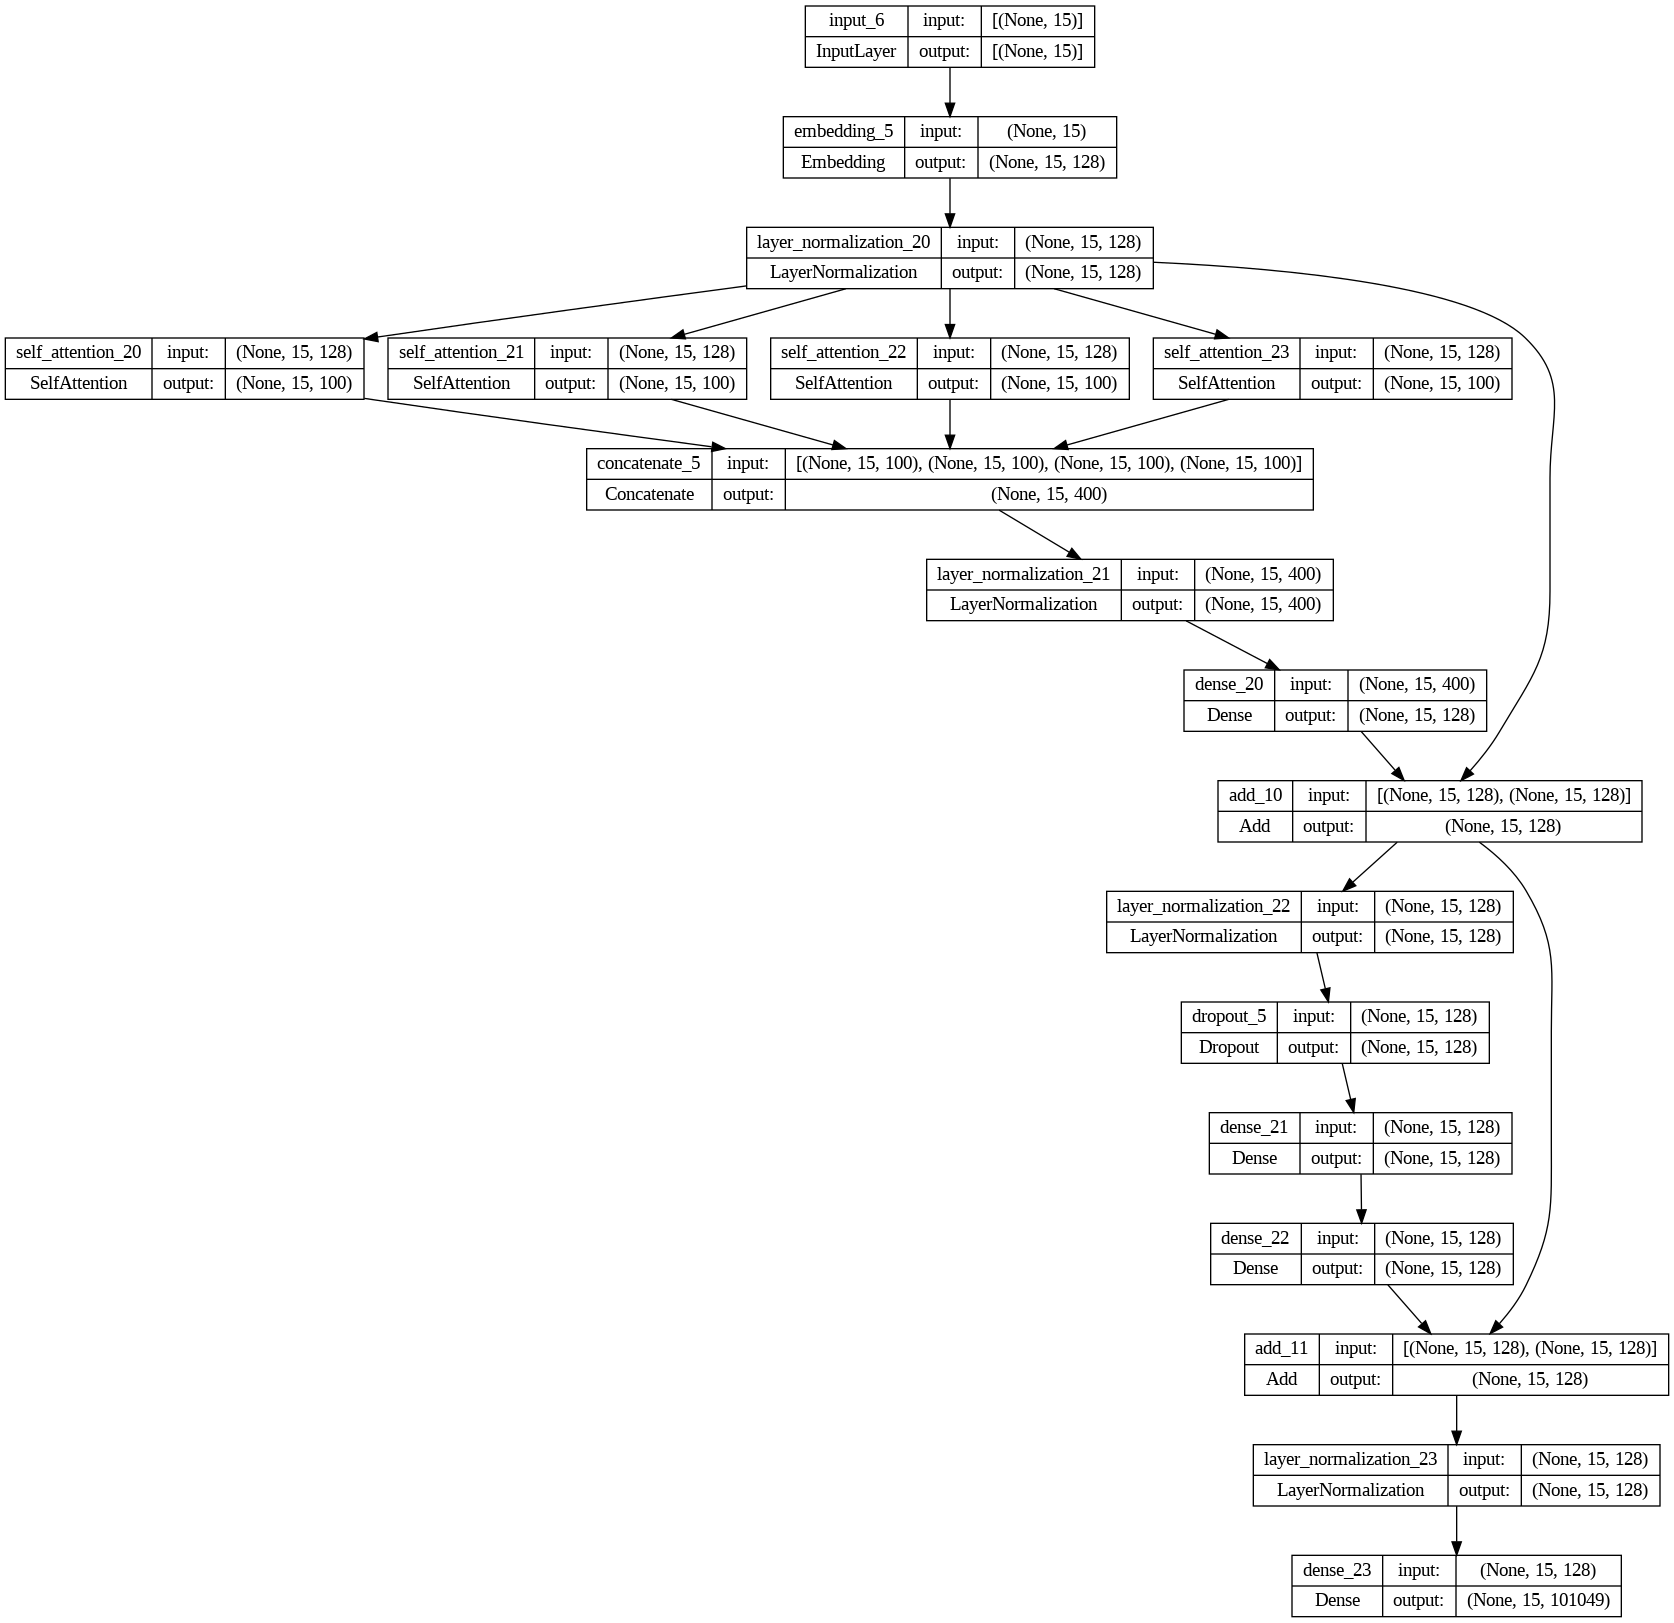

In [31]:
tf.keras.utils.plot_model(model,show_shapes=True)

<font color='red'> Training: </font>

In [ ]:
modelsave_wt = tf.keras.callbacks.ModelCheckpoint(
                     filepath='/content/drive/MyDrive/recommender/modeldata/model.{epoch:02d}-{masked_acc:.4f}.h5', 
                     save_freq='epoch', verbose=1, monitor='masked_acc', 
                     save_weights_only=True, save_best_only=True
                 ) 

In [33]:
buffer = 10000
batch_size = 1024

train = tf.data.Dataset.from_tensor_slices((train_pad, y_train_pad)).shuffle(buffer).batch(batch_size).repeat()
valn = tf.data.Dataset.from_tensor_slices((val_pad, y_val_pad)).shuffle(buffer).batch(batch_size)

In [34]:
train_steps=np.ceil(len(train_pad)/batch_size)
valid_steps=len(val_pad)//batch_size

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function,metrics=[masked_acc])
hist = model.fit(train, epochs=10, validation_data=valn,steps_per_epoch=train_steps,validation_steps=valid_steps)

Epoch 1/10
94/94 [==============================] - 112s 1s/step - loss: 4.3615 - masked_acc: 0.0041 - val_loss: 4.1805 - val_masked_acc: 0.0091
Epoch 2/10
94/94 [==============================] - 106s 1s/step - loss: 3.9898 - masked_acc: 0.0231 - val_loss: 4.0104 - val_masked_acc: 0.0431
Epoch 3/10
94/94 [==============================] - 98s 1s/step - loss: 3.5481 - masked_acc: 0.0889 - val_loss: 3.7206 - val_masked_acc: 0.1097
Epoch 4/10
94/94 [==============================] - 106s 1s/step - loss: 3.0373 - masked_acc: 0.1811 - val_loss: 3.4418 - val_masked_acc: 0.1830
Epoch 5/10
94/94 [==============================] - 98s 1s/step - loss: 2.5877 - masked_acc: 0.2674 - val_loss: 3.2429 - val_masked_acc: 0.2350
Epoch 6/10
94/94 [==============================] - 106s 1s/step - loss: 2.2330 - masked_acc: 0.3437 - val_loss: 3.1227 - val_masked_acc: 0.2664
Epoch 7/10
94/94 [==============================] - 106s 1s/step - loss: 1.9542 - masked_acc: 0.4035 - val_loss: 3.0589 - val_masked

- After trying various hyperparameters model is overfitting the train data.

- As we have seen that no. of items are more compared to sessions data and quantity of item is overall data is also less(about 50% data appears less than 3 times). recommender systems data are very sparse and quantity of items are huge.

- about 14% items in validation data is unseen.

- so the model may only be learning train data and fail to generalize due to data quality issues.

- we may need more sessions data to generalize well.
